# [Bonus Tasks](svm_segm.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [3]:
patch_sizes = (32, 32)

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [4]:
from skimage.util import view_as_blocks
import numpy as np

patch_sizes = (32, 32)

In [ ]:
 blocks = view_as_blocks(img, block_shape=patch_sizes)

In [10]:
def create_data_matrix(img):
    # Step 1: 按 patch_sizes 切图像
    blocks = view_as_blocks(img, block_shape=patch_sizes)
    
    # blocks 的形状为 (num_y, num_x, 32, 32)
    # Step 2: 合并前两个维度为一个 patch 维度
    num_patches = blocks.shape[0] * blocks.shape[1]
    
    # Step 3: reshape 成 (num_patches, 32*32)
    X = blocks.reshape(num_patches, -1)
    
    return X

**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [9]:
from skimage.util import view_as_blocks
import numpy as np

patch_sizes = (32, 32)

def create_gt_labels_vector(gt_img):
    # Step 1: 按 patch 分块
    blocks = view_as_blocks(gt_img, block_shape=patch_sizes)
    
    num_patches = blocks.shape[0] * blocks.shape[1]
    
    # Step 2: 为每个 patch 分配一个 label
    y = np.zeros(num_patches, dtype=int)
    
    # Step 3: 遍历所有 patch
    idx = 0
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            patch = blocks[i, j]

            # 计算 patch 中前景像素比例
            foreground_ratio = patch.mean()  # 因为前景=1、背景=0
            
            # 规则
            if foreground_ratio > 0.5:
                y[idx] = 1
            elif foreground_ratio == 0:
                y[idx] = -1
            else:
                y[idx] = 0
            
            idx += 1
    
    return y


**[Task 1.3.]()** Create the SVM classifier:

In [18]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

In [6]:
from skimage.io import imread

# 1. 读取两张训练图像
img1 = imread("data/NIH3T3/im/dna-33.png")
img2 = imread("data/NIH3T3/im/dna-44.png")

In [7]:
print(img1.shape)

(1024, 1344)


In [12]:
# 2. 生成每张图的 patch 数据矩阵
X1 = create_data_matrix(img1)   # 第一张图的所有 patch
X2 = create_data_matrix(img2)   # 第二张图的所有 patch

print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)

X1 shape: (1344, 1024)
X2 shape: (1344, 1024)


In [ ]:
X_train = np.vstack([X1, X2])
print("X_train shape:", X_train.shape)

**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [13]:
from skimage.io import imread

# 1. 读取两张 GT segmentation 图像
gt1 = imread("data/NIH3T3/gt/33.png")
gt2 = imread("data/NIH3T3/gt/44.png")

# 如果读进来不是二值（比如 0/255），可以先归一化成 0/1
#gt1 = (gt1 > 0).astype(float)
#gt2 = (gt2 > 0).astype(float)

# 2. 生成每张图的标签向量
y1 = create_gt_labels_vector(gt1)   # 对应 dna-33.png 的 patch 标签
y2 = create_gt_labels_vector(gt2)   # 对应 dna-44.png 的 patch 标签

print("y1 shape:", y1.shape)
print("y2 shape:", y2.shape)

# 3. 拼成总的训练标签向量（后面会把 0 类过滤掉）
y_train = np.concatenate([y1, y2])
print("y_train shape:", y_train.shape)


y1 shape: (1344,)
y2 shape: (1344,)
y_train shape: (2688,)


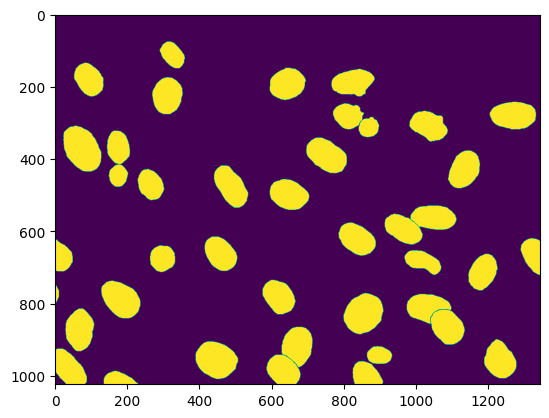

In [15]:
plt.imshow(gt1)

**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [16]:
# 1. 先把两个数据矩阵上下拼接
X_all = np.vstack([X1, X2])        # shape: (N_total, 1024)

# 2. 把两个标签向量拼接
y_all = np.concatenate([y1, y2])   # shape: (N_total,)

print("Before filtering:", X_all.shape, y_all.shape)

# 3. 只保留 y = -1 或 +1 的样本（丢掉 y = 0）
mask = (y_all != 0)

X_train = X_all[mask]
y_train = y_all[mask]

print("After filtering:", X_train.shape, y_train.shape)


Before filtering: (2688, 1024) (2688,)
After filtering: (2678, 1024) (2678,)


**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [19]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [20]:
def predict_image(img, clf, patch_sizes=(32,32)):
    # --- Step 1: 生成 patch 数据矩阵 X ---
    X = create_data_matrix(img)   # shape = (num_patches, 1024)
    
    # --- Step 2: 预测 patch-level 标签 ---
    pred_labels = clf.predict(X)  # shape = (num_patches,), values in {+1, -1}
    
    # --- Step 3: 根据标签重建 segmentation mask ---
    # 获取图像可以分成多少个 patch
    H, W = img.shape
    ph, pw = patch_sizes
    num_y = H // ph    # patch rows
    num_x = W // pw    # patch cols

    # 用 False 初始化全图 segmentation
    result = np.zeros((H, W), dtype=bool)

    # 将预测标签重新映射回 patch 位置
    idx = 0
    for i in range(num_y):
        for j in range(num_x):
            label = pred_labels[idx]
            
            # 如果这一块被预测为前景（+1），则该 patch 区域全 True
            if label == 1:
                result[i*ph:(i+1)*ph, j*pw:(j+1)*pw] = True

            idx += 1

    return result


Test your implementation:

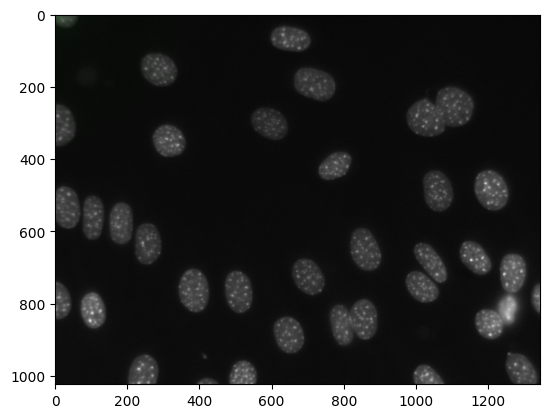

In [22]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
seg = predict_image(img,clf)

plt.figure()
plt.imshow(blend_result(img, seg))

**[Task 1.5.]()** Perform batch processing:

In [23]:
def dice_score(pred, gt):
    # pred 和 gt 都是 True/False 类型
    pred = pred.astype(bool)
    gt   = gt.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    size_pred = pred.sum()
    size_gt = gt.sum()

    if size_pred + size_gt == 0:
        return 1.0  # 两者都没前景时 Dice=1

    return 2 * intersection / (size_pred + size_gt)


In [25]:
test_ids = [28, 29, 33, 44, 46, 49]

dice_values = []

for i in test_ids:
    # 1. 读取测试图像
    img = plt.imread(f"data/NIH3T3/im/dna-{i}.png")
    if img.ndim == 3:
        img = img.mean(axis=2)
    
    # 2. 读取 ground truth
    gt = plt.imread(f"data/NIH3T3/gt/{i}.png")
    gt = (gt > 0).astype(bool)

    # 3. patch-based segmentation
    seg = predict_image(img,clf)   # 注意：你的 predict_image 默认使用全局 clf

    # 4. Dice 系数
    d = dice_score(seg, gt)
    dice_values.append(d)

    # 打印结果
    print(f"Image {i}: Dice = {d:.4f}")

# 5. 打印平均 Dice
mean_dice = np.mean(dice_values)
print("-" * 40)
print(f"Mean Dice over all images: {mean_dice:.4f}")


Image 28: Dice = 0.3158
Image 29: Dice = 0.2837
Image 33: Dice = 0.2913
Image 44: Dice = 0.4091
Image 46: Dice = 0.3128
Image 49: Dice = 0.4015
----------------------------------------
Mean Dice over all images: 0.3357
